In [354]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

In [355]:
import  warnings 
warnings.simplefilter('ignore')
# Configurando tamanho das imagens
rcParams['figure.figsize'] = 15, 6

In [356]:
# Função para plotar o ACF E PACF
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

In [357]:
df = pd.read_csv("Data/MVF.csv", sep=";")
df = df.set_index('time')
df.head(2)

,target
time,
1,150
2,117


In [358]:
train = df.loc[0:72]
test = df.loc[72:84]

#### Modelo Auto Regressivo Integrado de Média Móvel - ARIMA(p,d,q)


* Generalização de modelos ARMA(p,q) aplicado para séries não estacionárias;
* Adiciona o componente de integração (d);

**Casos especiais**:

* **Ruído Branco**: ARIMA(0,0,0);

* **Random Walk**: ARIMA(0,1,0) sem a constante;

* **Autoregressivo**: ARIMA(p,0,0);

* **Média Móvel**: ARIMA(0,0,q);

**Vantagens**:
* Poucos parâmetros;
* Rápido;
* “Interpretável”;

**Desvantagens**:
* Exige conhecimento da série temporal;
* Sensível aos parâmetros selecionados;
* Assume que a série é linear;
* Fraco desempenho em séries com alta volatilidade e com sazonalidade;



#### Metodologia Box-Jenkins
Tem como objetivo encontrar os melhores parâmetros para o modelo representar a série temporal;

* **(1) Identificação**: Um modelo para a série é identificado. A correlação entre observações nos dados da série temporal é investigada;

* **(2.1) Estimação**: Estima-se os parâmetros do modelo identificado ;

* **(2.2) Avaliação/Diagnóstico**: O modelo estimado é avaliado;

* **(3) Previsão**: O modelo é utilizado para prever valores futuros da série;

#### (1) Identificação:

**Escolha do parâmetro (d)**:
Uma série que não apresenta estacionariedade tem as autocorrelações com valores absolutos altos para todos os lags.

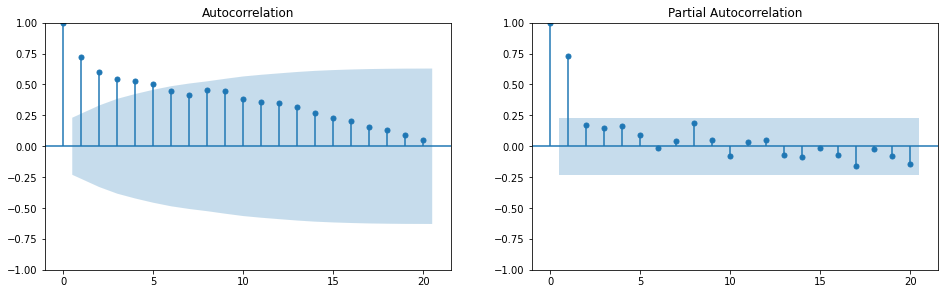

In [359]:
acf_pacf(train, 20)

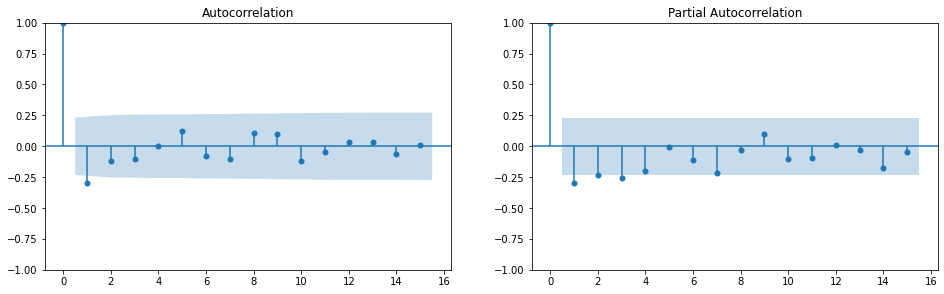

In [360]:
acf_pacf(train.diff().dropna(), 15)

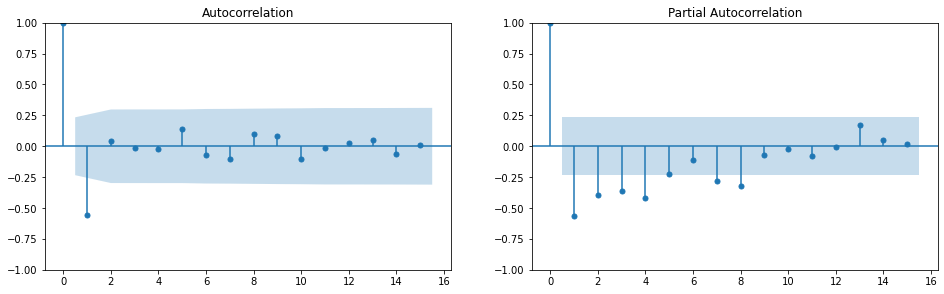

In [361]:
acf_pacf(train.diff().diff().dropna(), 15)

In [362]:
arima_d = 1

**Escolha do parâmetro (p)**: O valor de p (que corresponde ao grau de polinômios do componente AR) pode ser selecionado através da função de autocorrelação parcial, sendo p = número de lags correlacionados.


In [363]:
arima_p = 2

**Escolha do parâmetro (q)**: O valor de q (que corresponde ao grau de polinômios do componente MA) pode ser selecionado através da função de autocorrelação, sendo q = número de lags correlacionados.


In [364]:
arima_q = 1

**Obs.**: Geralmente, na prática a maioria das séries estacionárias apresentam  p + q ≤ 2. Porém não é uma regra.  

#### (2.1) Estimação:
Nessa etapa os valores dos parâmetros são estimados.

In [365]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.target, order=(arima_p, arima_d, arima_q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                   72
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -342.281
Date:                Sat, 03 Sep 2022   AIC                            692.563
Time:                        06:27:10   BIC                            701.613
Sample:                             0   HQIC                           696.162
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2765      0.199      1.391      0.164      -0.113       0.666
ar.L2         -0.0700      0.153     -0.457      0.648      -0.370       0.230
ma.L1         -0.7660      0.164     -4.662      0.0

#### (2.2) Avaliação/Diagnóstico:
Essa etapa consiste em avaliar se o modelo estimado para a série está representando adequadamente o comportamento da série. 
* **Princípio da parcimônia**: entre 2 modelos que representam bem a série, é selecionado o modelo que tem o menor número de parâmetros;
* **Análise de Resíduos**model_fit: Se o modelo estiver representando bem a série temporal, os resíduos devem ser um ruído branco.

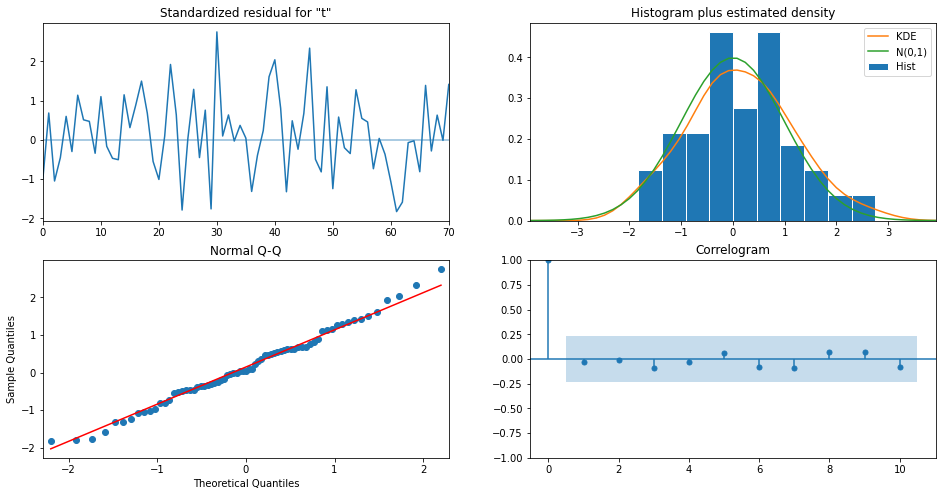

In [366]:
model_fit.plot_diagnostics(figsize=(16,8));

#### (3) Previsão:

Etapa em que é utilizado o modelo estimado para a previsão de séries temporais $h$ passos à frente.

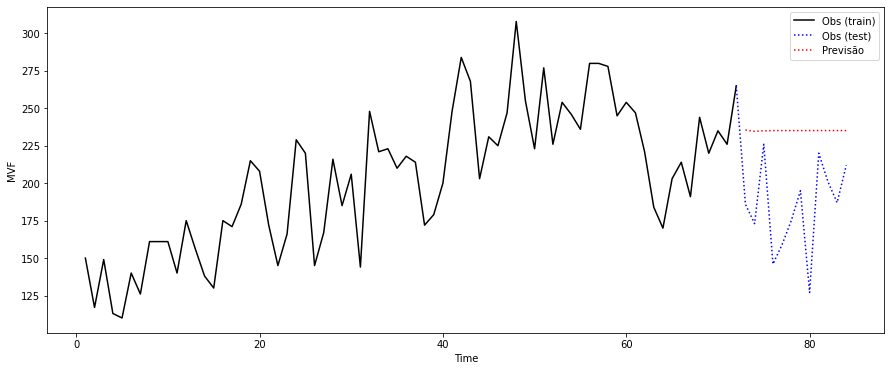

73    235.518317
74    234.628229
75    234.978333
76    235.137390
77    235.156873
78    235.151133
79    235.148183
80    235.147769
81    235.147861
82    235.147915
83    235.147924
84    235.147923
Name: predicted_mean, dtype: float64

In [367]:
previsao = model_fit.predict(start=(len(train)+1), end=len(train+test))

obs_train = plt.plot(train.target, color='black', label='Obs (train)')
obs_test = plt.plot(test.target, color='blue', label= 'Obs (test)', linestyle='dotted')#, 'bo') 
pred = plt.plot(previsao, color='red', label='Previsão', linestyle='dotted')#, 'bo') 

plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("MVF")
plt.show()
previsao

,pred,obs
73,235.518317,186
74,234.628229,173
75,234.978333,226
76,235.137390,146
77,235.156873,159
78,235.151133,175
79,235.148183,195
80,235.147769,127
81,235.147861,220
82,235.147915,201


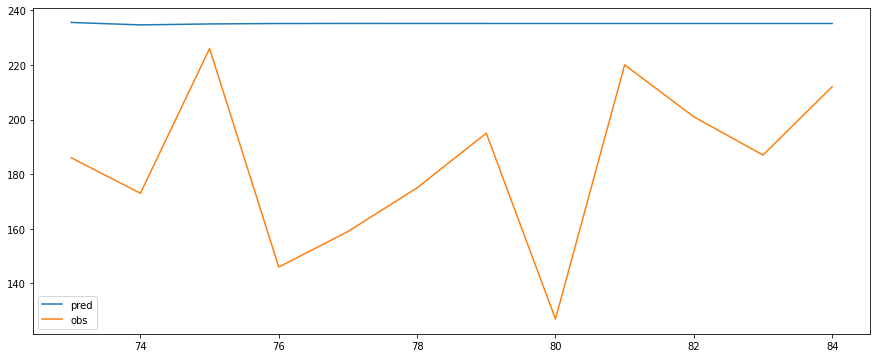

In [368]:
pred = model_fit.predict(start=(len(train)+1), end=len(test+train))
obs = test.target

pred_df = pd.DataFrame()
pred_df['pred'] = pred
pred_df['obs'] = obs

pred_df.plot()
pred_df

#### Extra: Previsão One-Step Ahead

In [427]:
history = [x for x in train.target]
predictions = list()

for t in test.index:
    model = ARIMA(history, order=(2, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast(alpha=0.05)
    yhat = output[0]
    predictions.append(yhat)
    obs = float(test.loc[t].values)
    history.append(obs)
    print('predicted=%f' % (yhat))

predicted=255.584816
predicted=259.157074
predicted=215.932845
predicted=196.853286
predicted=213.515070
predicted=161.658532
predicted=176.239236
predicted=166.207785
predicted=184.546626
predicted=146.822857
predicted=200.575010
predicted=184.560187
predicted=199.187362


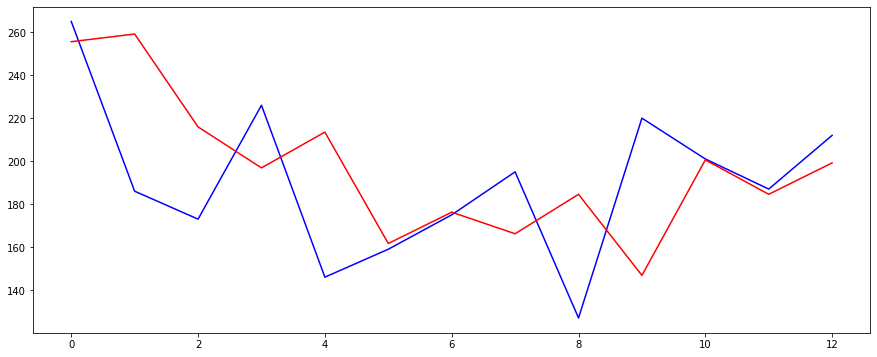

In [425]:
# plot
plt.plot(test.values, color='blue', label='Obs (train)')
plt.plot(predictions, color='red',  label='Previsão')
plt.show()